## Inisialisasi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Memuat Data

*Dataset* yang Anda perlukan disimpan di folder `/datasets/faces/`. Pada folder tersebut, Anda bisa menemukan: - Folder `final_file` dengan 7,6 ribu foto
- *File* `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age`

Mengingat jumlah *file* gambar cukup banyak, Anda disarankan untuk tidak membacanya sekaligus, karena hal ini hanya akan menghabiskan sumber daya komputasi. Kami sarankan Anda untuk membuat generator dengan ImageDataGenerator. Metode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran ke-7.

*File* label bisa dimuat sebagai *file* CSV biasa.

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [ ]:
features,target= next(train_datagen_flow)

In [ ]:
features.shape

(16, 224, 224, 3)

In [ ]:
target.shape

(16,)

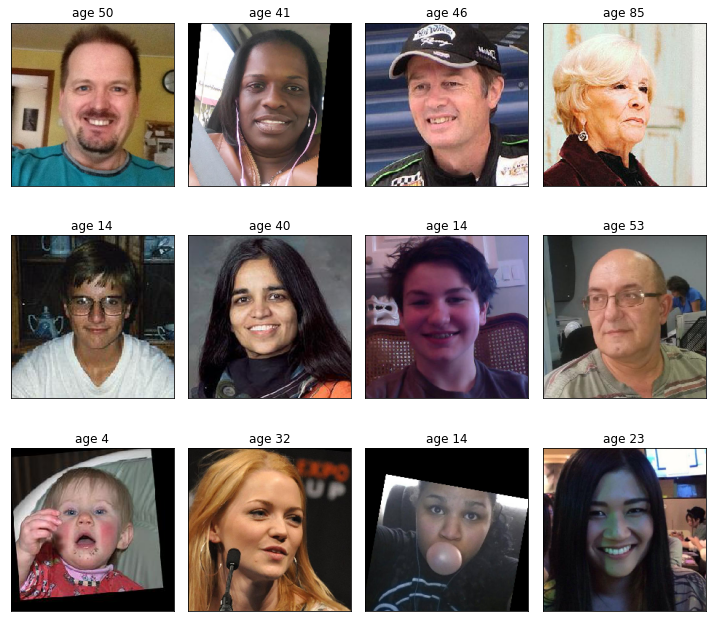

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'age {target[i]}')
    plt.tight_layout()

In [ ]:
labels['real_age'].value_counts().head()


30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

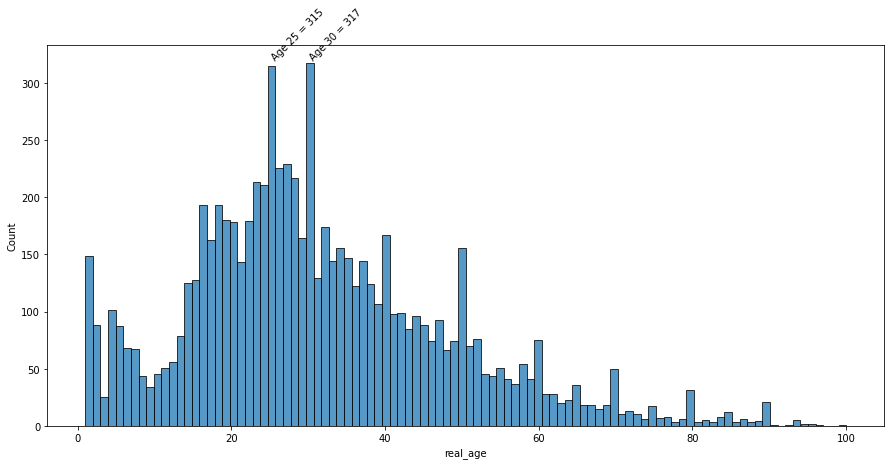

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(labels['real_age'],bins=100)
plt.text(30,320,f'Age 30 = 317',rotation=45)
plt.text(25,320,f'Age 25 = 315',rotation=45)
plt.show()

### Temuan

In [ ]:
highlight = labels[labels['real_age'].isin(target)].reset_index(drop=True)

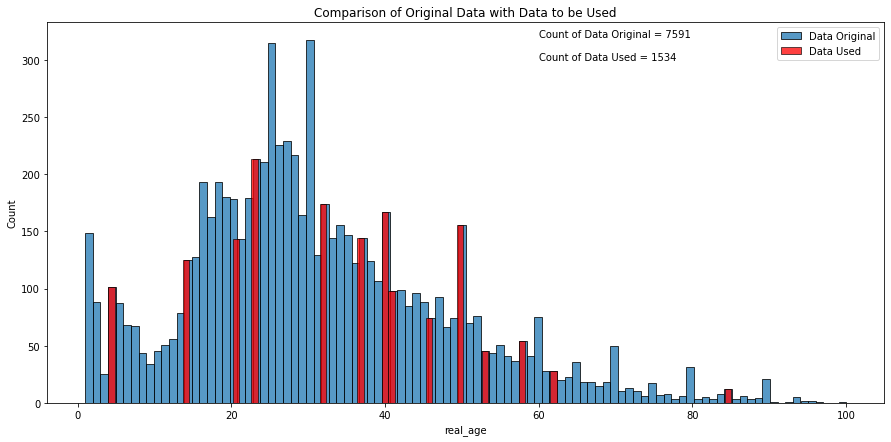

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(labels['real_age'],bins=100,label='Data Original')
sns.histplot(highlight['real_age'],bins=100,color='red',label='Data Used')
plt.title('Comparison of Original Data with Data to be Used')
plt.text(60,320,f'Count of Data Original = {labels.count()[0]}')
plt.text(60,300,f'Count of Data Used = {highlight.count()[0]}')
plt.legend()
plt.show()

## Pemodelan

Definisikan fungsi-fungsi yang diperlukan untuk melatih model Anda pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.

Untuk mempermudah tugas ini, Anda dapat mendefinisikannya dalam *notebook* ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Definisi di bawah ini juga akan diperiksa oleh *project reviewer* agar mereka dapat memahami cara Anda membangun model.

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen=ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.25)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen=ImageDataGenerator(rescale=1./255,
                               validation_split=0.25)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


In [ ]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae']
    )
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    train_datagen_flow = train_data
    val_datagen_flow = test_data
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)
    return model

## Siapkan Skrip untuk menjalankan platform GPU

Setelah Anda mendefinisikan fungsi-fungsi yang diperlukan, Anda dapat membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip Anda juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [ ]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


### Output

Letakkan *output* dari platform GPU sebagai sel *Markdown* di sini.

## Kesimpulan